In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({"font.family":"serif", "font.size":12})

from pathlib import Path
import os

import numpy as np
import xarray as xr
import dask.array as da
import h5py

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(address=cluster)
client

In [2]:
def open_dedalus(path, sim_t_as_coord=True, chunks=None):
    nc = h5py.File(path, "r")

    ds = xr.Dataset(data_vars={key:(tuple([dim.label for dim in val.dims]), 
                                    da.from_array(val, chunks=val.chunks)
                                   ) for key,val in nc["tasks"].items()}
                   )
    if chunks is not None:
        ds = ds.chunk(chunks)

    if "t" in ds.dims:
        ds = ds.assign_coords(iteration=xr.DataArray(nc["scales"]["iteration"][:], dims=('t',)), 
                             sim_time=xr.DataArray(nc["scales"]["sim_time"][:], dims=('t',)))
        if sim_t_as_coord:
            ds = ds.rename({"sim_time":"t"})
        else:
            ds = ds.assign_coords(t=xr.DataArray(nc["scales"]["write_number"][:], dims=('t',)))

    space_dims = ["x", "y"]
    for dim in space_dims:
        if dim in ds.dims:
            ds = ds.assign_coords({dim:xr.DataArray(nc["scales"][dim]["1.0"][:], dims=(dim,))})
            ds.attrs["d"+dim] = ds[dim].diff(dim).mean().values
    return ds

In [3]:
if True:
    data_path = Path(os.getenv("HOME")+"/working_on/MHD/data_work")
else:
    data_path = Path(os.getenv("SCRATCH")+"/MHD/data")
simul = Path("modon_N512d_Bu1p0_kaip0p00_kaxp0p20_1nu33_Pr1p0")
filetype = "snapshots/snapshots.h5"

do_savefig = False
dirpic = Path("./figures/all_runs/")

In [4]:
ds = open_dedalus(data_path/simul/filetype, sim_t_as_coord=True, chunks={"x":-1, "y":-1})
ds

<xarray.Dataset>
Dimensions:    (t: 160, x: 704, y: 512)
Coordinates:
    iteration  (t) int64 0 353 705 1057 1409 ... 37681 37825 37969 38114 38262
  * t          (t) float64 0.0 0.5006 1.001 1.501 2.001 ... 78.0 78.5 79.0 79.5
  * x          (x) float64 -6.875 -6.855 -6.836 -6.816 ... 6.816 6.836 6.855
  * y          (y) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
Data variables:
    b          (t, x, y) float64 dask.array<chunksize=(10, 704, 512), meta=np.ndarray>
    psi        (t, x, y) float64 dask.array<chunksize=(10, 704, 512), meta=np.ndarray>
    vort       (t, x, y) float64 dask.array<chunksize=(10, 704, 512), meta=np.ndarray>
Attributes:
    dx:       0.01953125
    dy:       0.019531249999999997

### first type of plot

In [13]:
fies = ["psi", "vort", "A"]
cmaps = {"psi": "PRGn", "A":"gray_r", "vort":"RdBu_r"}
levs_psi = np.linspace(-1, 1, 20) # even number of levels for 0 in white
levs_buoy = np.linspace(-.1, .1, 8)[:4] # likewise, even number of levels for no 0
tits = [r"$\Psi$", r"$\zeta$", r"$B$ and $|\vec{A}|$"]

amp_vort = 25
amp_A = .25

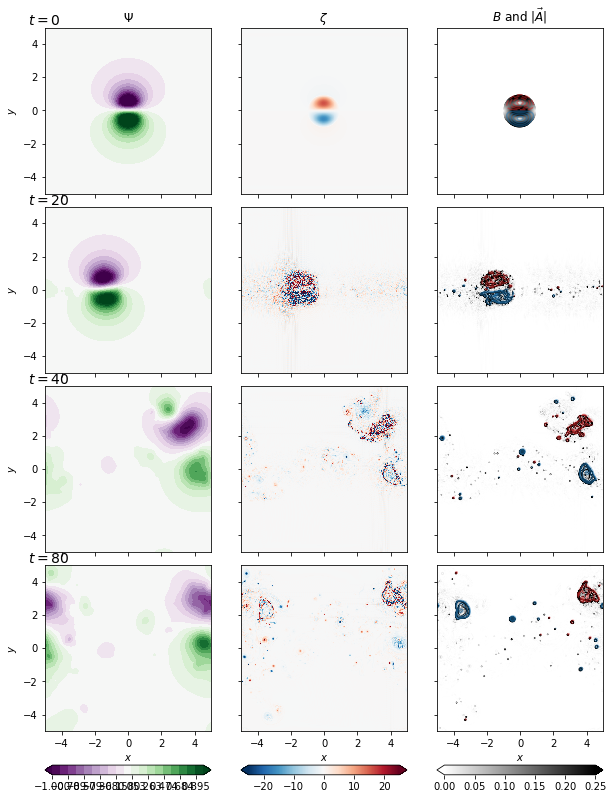

In [14]:
tplots = [0, 20, 40, 80]

xplot, yplot = ds.x.values, ds.y.values
fig, axs = plt.subplots(len(tplots), 3, sharex=True, sharey=True, figsize=(10, 3*len(tplots)))
hpc = {}
for it,tt in enumerate(tplots):
    ax = axs[it,0] # streamfunction
    sds = ds.sel(t=tt, method="nearest")
    psi = sds.psi.transpose("y", "x").values
    hpc["psi"] = axs[it,0].contourf(xplot, yplot, psi, cmap=cmaps["psi"], levels=levs_psi, extend="both")
    ax = axs[it,1] # vorticity
    hpc["vort"] = sds.vort.plot(ax=ax, cmap=cmaps["vort"], vmin=-amp_vort, vmax=amp_vort, y="y", add_colorbar=False)
    ax.set_title("")
    ax = axs[it,2]
    buoy = sds.b.load()
    buoy.plot.contour(ax=ax, colors="tab:red", levels=levs_buoy, alpha=.5, linestyles="--", y="y")
    sds.b.plot.contour(ax=ax, colors="tab:blue", levels=-levs_buoy[::-1], alpha=.5, y="y")
    Ax, Ay = -buoy.differentiate("y"), buoy.differentiate("x")
    buoy = (Ax**2 + Ay**2)**.5
    hpc["A"] = buoy.plot(ax=ax, cmap=cmaps["A"], vmin=0, vmax=amp_A, y="y", add_colorbar=False)
    ax.set_title("")
  
### Deal with axes labels and titles
for ax in axs.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect(1)
for ax in axs[:,0]:
    ax.set_ylabel(r'$y$')
for ax in axs[-1,:]:
    ax.set_xlabel(r'$x$')
for it,tit in enumerate(tits):
    axs[0,it].set_title(tit)
for it,ti in enumerate(tplots):
    axs[it,0].text(-.1, 1.015, r"$t=$"+"{:.0f}".format(ti), fontsize=14, transform=axs[it,0].transAxes)
    
### deal with colorbars
ntp = len(tplots)
fig.subplots_adjust(bottom=.2/ntp, wspace=.18, hspace=0)
for ifi,fie in enumerate(fies):
    pos = axs[0,ifi].get_position()
    posx, sizx = pos.intervalx[0], pos.width
    cax = fig.add_axes([posx,.03/ntp,sizx,.045/ntp])
    hcb = plt.colorbar(hpc[fie], extend="both", cax=cax, orientation="horizontal")

if do_savefig:
    fig_name = simul.name+"_snapshots.png"
    fig.savefig(dirpic/fig_name, dpi=250, bbox_inches="tight", magnification="auto")

### second type of plots

In [5]:
fies = ["psi", "vort", "B"]
cmaps = {"psi": "PRGn", "B":"BrBG", "vort":"RdBu_r"}
levs_psi = np.linspace(-1.5, 1.5, 10) # even number of levels for 0 in white
tits = [r"$\Psi$", r"$\zeta$", r"$A$"]

Lplot = 3.5
amp_vort = 15
amp_Bext = .2
amp_B = .2

fig_path = Path("./figures")/simul
if not fig_path.exists():
    fig_path.mkdir()
    
slih = slice(-Lplot, Lplot)

In [6]:
### processing routines

import scipy.fft as fft

def get_fft_diff(da, axis=-1, d=1.0):
    """ did not tested if da is not 2D """
    n = da.shape[axis]
    k = fft.rfftfreq(n, d=d)*2*np.pi
    k = np.expand_dims(k, tuple([k for k in range(len(da.shape)-1) ]) )
    return fft.irfft(1.j*k*fft.rfft(da, axis=axis), axis=axis)

def get_fft_ddif(da, axis=-1, d=1.0):
    """ 2nd derivative using fft """
    n = da.shape[axis]
    k = fft.rfftfreq(n, d=d)*2*np.pi
    k = np.expand_dims(k, tuple([k for k in range(len(da.shape)-1) ]) )
    return -fft.irfft(k**2*fft.rfft(da, axis=axis), axis=axis)

def wrap_fft_diff(data, coord, d=1.0):
    return xr.apply_ufunc(get_fft_diff, data, input_core_dims=[[coord]], output_core_dims=[[coord]],
                         kwargs={"d":d}, dask="parallelized",  
                         output_dtypes=data.dtype)

def wrap_fft_lap(data, dx=1.0, dy=1.0):
    dxx = xr.apply_ufunc(get_fft_ddif, data, input_core_dims=[["x"]], output_core_dims=[["x"]],
                         kwargs={"d":dx}, dask="parallelized",  
                         output_dtypes=data.dtype)
    dyy = xr.apply_ufunc(get_fft_ddif, data, input_core_dims=[["y"]], output_core_dims=[["y"]],
                         kwargs={"d":dy}, dask="parallelized",  
                         output_dtypes=data.dtype)
    return dxx + dyy
    
def get_grad(ds, what="psi", uv=True):
    rds = xr.Dataset()
    if what in ["psi"]:
        namx, namy = "v", "u"
    elif what in ["b"]:
        namx, namy = "Bx", "By"
    if uv:
        sigx, sigy = 1., -1
    else:
        sigx, sigy = +1., +1.
    rds[namx] = sigx * wrap_fft_diff(ds[what], "x", d=ds.dx)
    rds[namy] = wrap_fft_diff(ds[what], "y", d=ds.dy)
    return rds

In [7]:
duv = get_grad(ds)
%time pos = ((duv.u**2 + duv.v**2)**.5).max("y").argmax("x").compute()
x_pos = (np.unwrap((pos-ds.x.size//2)*2*np.pi/ds.x.size)*ds.x.size/2/np.pi + ds.x.size//2) * ds.dx + float(ds.x[0])

ds_roll = xr.concat([ds.isel(t=[it]).roll({"x":-int(pos[it]-ds.x.size/2)}, roll_coords=False) for it in range(ds.t.size)], dim="t")
ds_roll = ds_roll.assign_coords(x_pos = xr.DataArray(data=x_pos, dims=("t",)))
ds_roll

CPU times: user 3.42 s, sys: 1.01 s, total: 4.42 s
Wall time: 7.71 s


<xarray.Dataset>
Dimensions:    (t: 160, x: 704, y: 512)
Coordinates:
    iteration  (t) int64 0 353 705 1057 1409 ... 37681 37825 37969 38114 38262
  * t          (t) float64 0.0 0.5006 1.001 1.501 2.001 ... 78.0 78.5 79.0 79.5
  * x          (x) float64 -6.875 -6.855 -6.836 -6.816 ... 6.816 6.836 6.855
  * y          (y) float64 -5.0 -4.98 -4.961 -4.941 ... 4.922 4.941 4.961 4.98
    x_pos      (t) float64 0.0 0.5078 1.016 1.504 ... 38.98 39.2 39.38 39.2
Data variables:
    b          (t, x, y) float64 dask.array<chunksize=(1, 704, 512), meta=np.ndarray>
    psi        (t, x, y) float64 dask.array<chunksize=(1, 704, 512), meta=np.ndarray>
    vort       (t, x, y) float64 dask.array<chunksize=(1, 704, 512), meta=np.ndarray>
Attributes:
    dx:       0.01953125
    dy:       0.019531249999999997

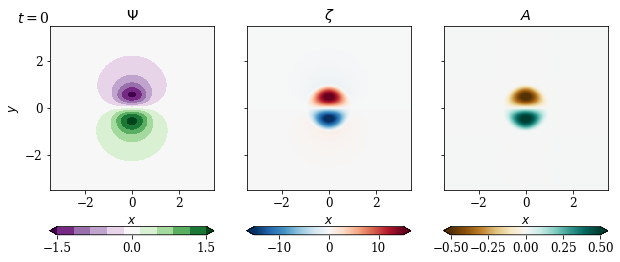

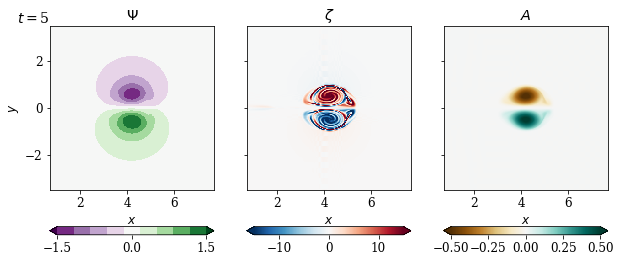

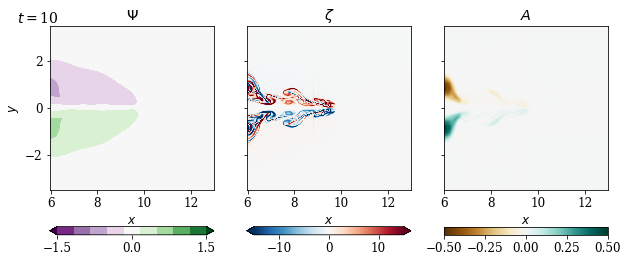

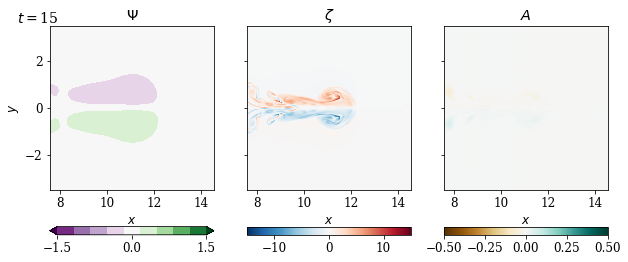

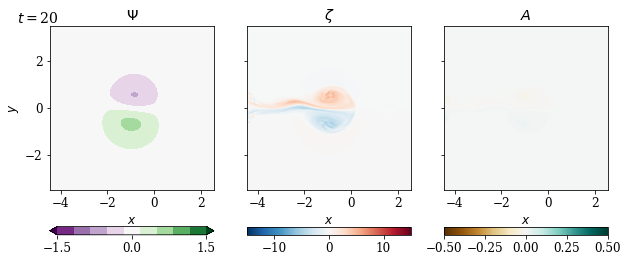

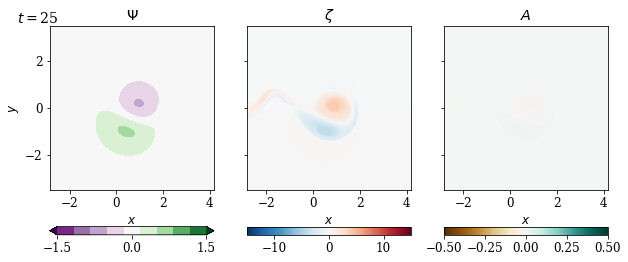

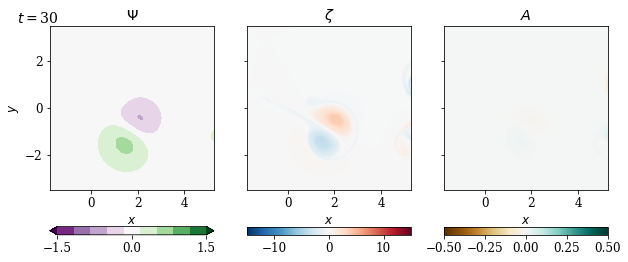

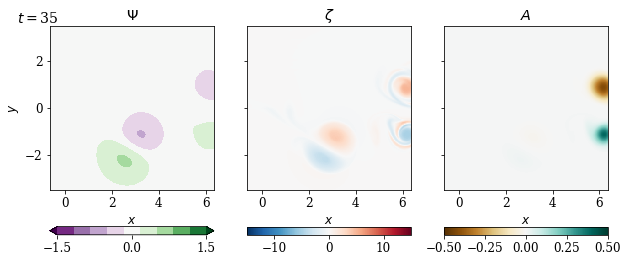

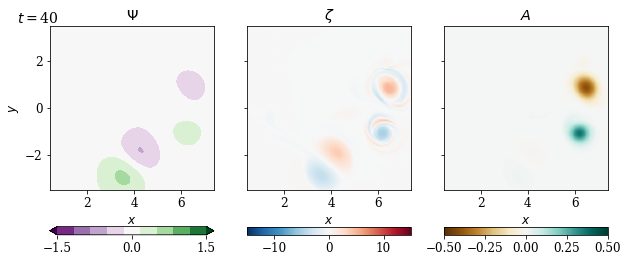

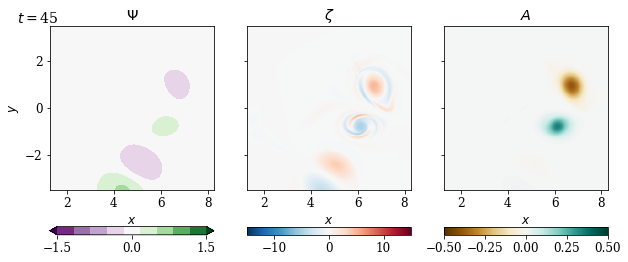

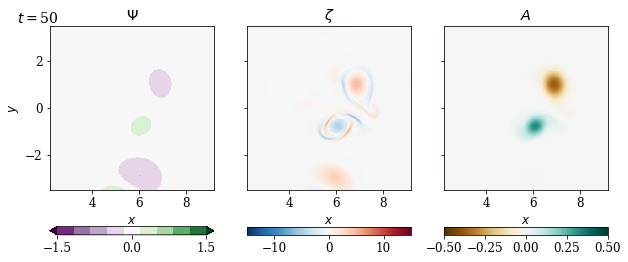

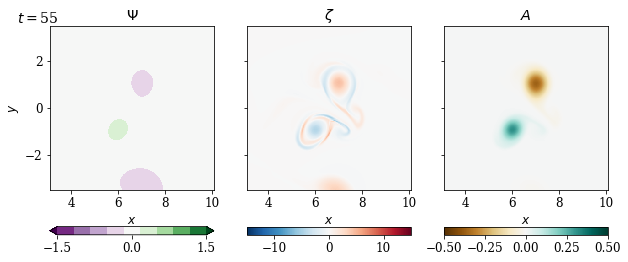

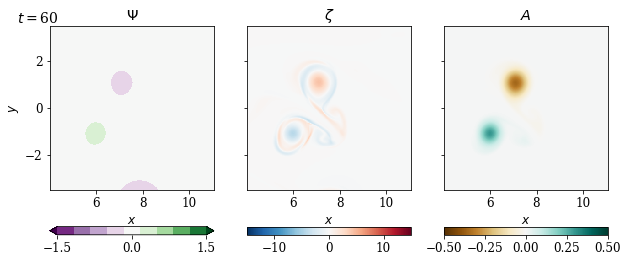

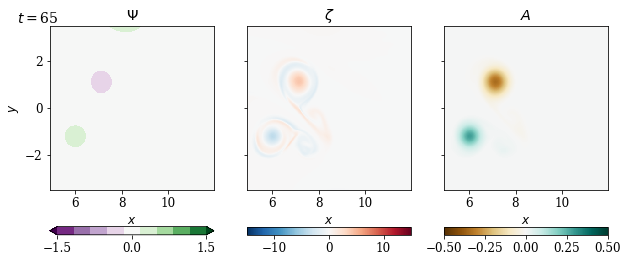

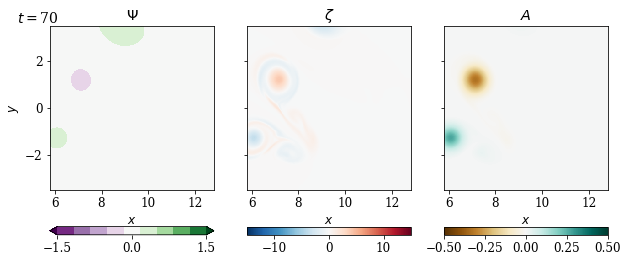

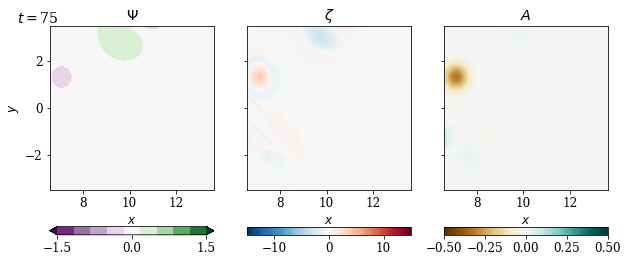

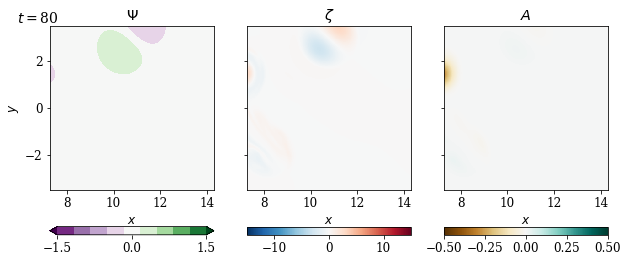

In [16]:
tplots = np.arange(0, 81, 5).tolist()
cbar_kwargs = {"orientation":"horizontal", "label":None}

hpc = {}
for it,tt in enumerate(tplots):
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4.5))
    ax = axs[0] # streamfunction
    sds = ds_roll.sel(t=tt, method="nearest").sel(x=slih, y=slih)
    sds["x"] = sds.x + sds.x_pos
    #xplot, yplot = sds.x.values, sds.y.values
    #psi = sds.psi.transpose("y", "x").values
    #hpc["psi"] = axs[0].contourf(xplot, yplot, psi, cmap=cmaps["psi"], 
    #                                levels=levs_psi, extend="both")
    #plt.colorbar(hpc["psi"], ax=ax, label="psi", **cbar_kwargs)
    hpp = sds.psi.plot.contourf(ax=ax, y="y", levels=levs_psi, cmap=cmaps["psi"], 
                          extend="both", cbar_kwargs=cbar_kwargs)
    hpp.colorbar.set_ticks([levs_psi[0], 0., levs_psi[-1]])
    ax = axs[1] # vorticity
    hpc["vort"] = sds.vort.plot(ax=ax, cmap=cmaps["vort"], vmin=-amp_vort, vmax=amp_vort, y="y", 
                                cbar_kwargs=cbar_kwargs)
    ax.set_title("")
    ax = axs[2]
    hpc["B"] = (sds.b+amp_Bext*sds.y).plot(ax=ax, cmap=cmaps["B"], y="y", vmin=-amp_B, vmax=amp_B, 
                          cbar_kwargs=cbar_kwargs)
    ax.set_title("")
  
    for ia,ax in enumerate(axs):
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'')
        ax.set_aspect(1)
        ax.set_title(tits[ia])

    axs[0].set_ylabel(r'$y$')
    axs[0].text(-.2, 1.02, r"$t=$"+"{:.0f}".format(tt), fontsize=14, transform=axs[0].transAxes)
    
    if True:
        fig_name = simul.name+"_snapshot_t{:02d}.png".format(round(tt))
        fig.savefig(fig_path/fig_name, dpi=250, bbox_inches="tight")

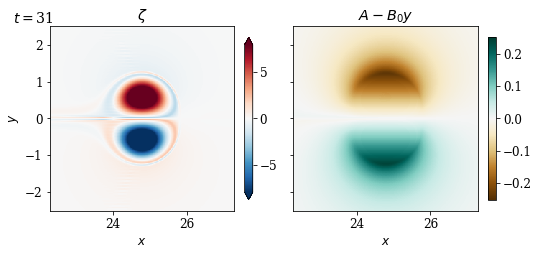

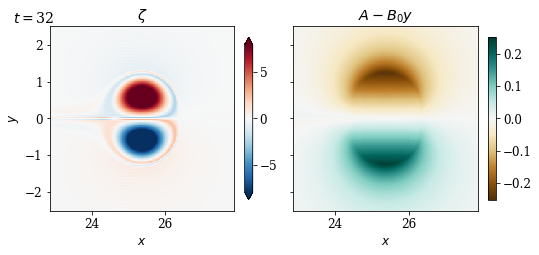

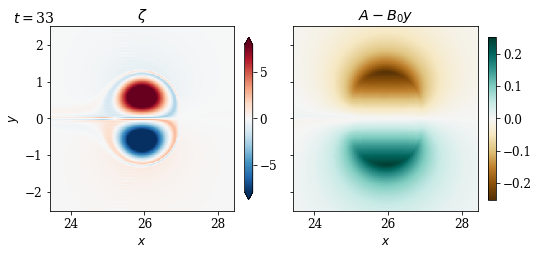

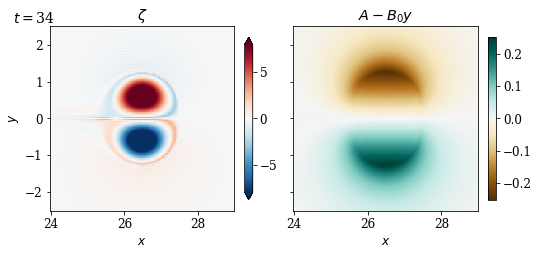

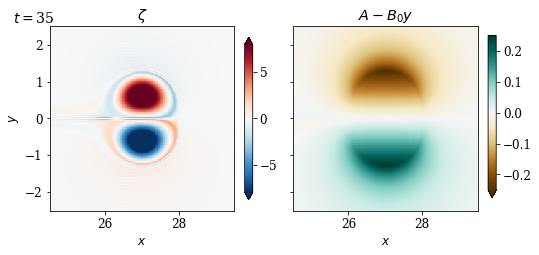

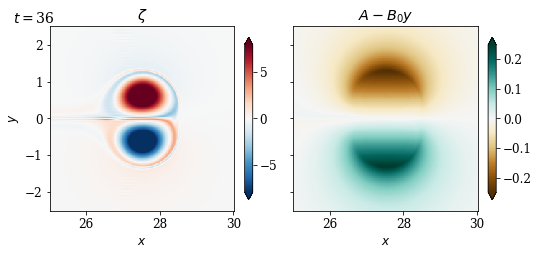

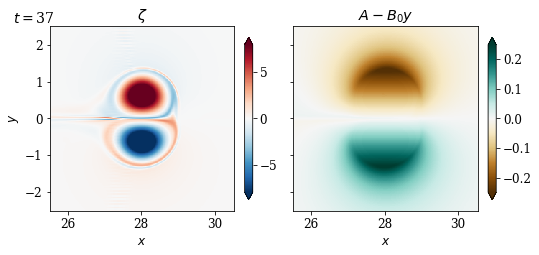

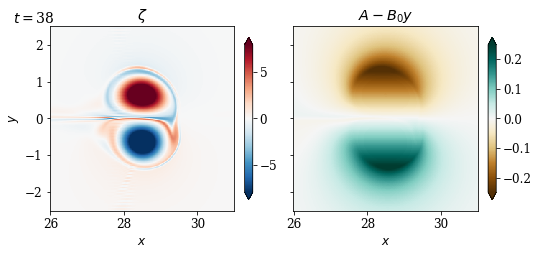

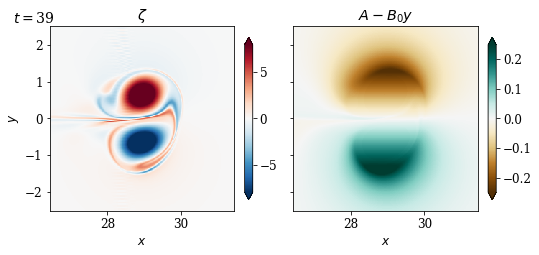

In [22]:
### zoomed version witb anomaly of A
Lplot = 2.5
amp_vort = 8
amp_B = .25
    
slih = slice(-Lplot, Lplot)
tplots = np.arange(31, 40, 1).tolist()
cbar_kwargs = {"orientation":"vertical", "label":None, "fraction":.04}

hpc = {}
for it,tt in enumerate(tplots):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4.5))
    ax = axs[0] # streamfunction
    sds = ds_roll.sel(t=tt, method="nearest").sel(x=slih, y=slih)
    sds["x"] = sds.x + sds.x_pos
    #xplot, yplot = sds.x.values, sds.y.values
    #psi = sds.psi.transpose("y", "x").values
    #hpc["psi"] = axs[0].contourf(xplot, yplot, psi, cmap=cmaps["psi"], 
    #                                levels=levs_psi, extend="both")
    #plt.colorbar(hpc["psi"], ax=ax, label="psi", **cbar_kwargs)
    hpc["vort"] = sds.vort.plot(ax=ax, cmap=cmaps["vort"], vmin=-amp_vort, vmax=amp_vort, y="y", 
                                cbar_kwargs=cbar_kwargs)
    ax.set_title(r"$\zeta$")
    ax = axs[1]
    hpc["B"] = sds.b.plot(ax=ax, cmap=cmaps["B"], y="y", vmin=-amp_B, vmax=amp_B, 
                          cbar_kwargs=cbar_kwargs)
    ax.set_title(r"$A-B_0y$")
    for ia,ax in enumerate(axs):
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'')
        ax.set_aspect(1)

    axs[0].set_ylabel(r'$y$')
    axs[0].text(-.2, 1.02, r"$t=$"+"{:.0f}".format(tt), fontsize=14, transform=axs[0].transAxes)
    
    if True:
        fig_name = simul.name+"_snapzoom_t{:02d}.png".format(round(tt))
        fig.savefig(fig_path/fig_name, dpi=250, bbox_inches="tight")

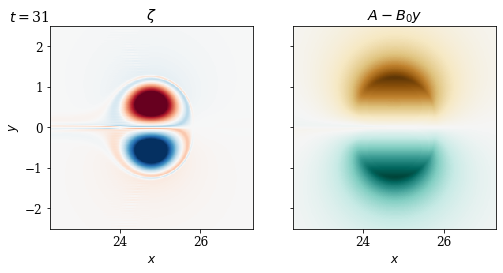

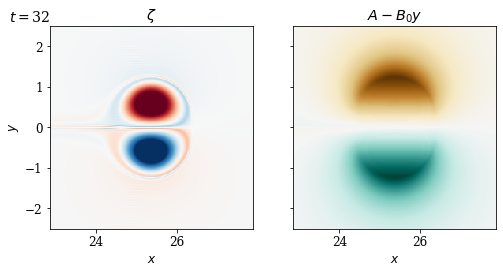

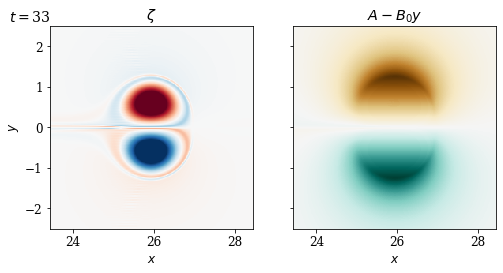

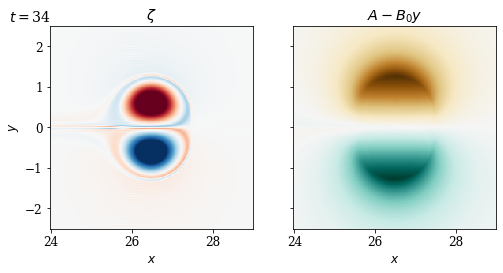

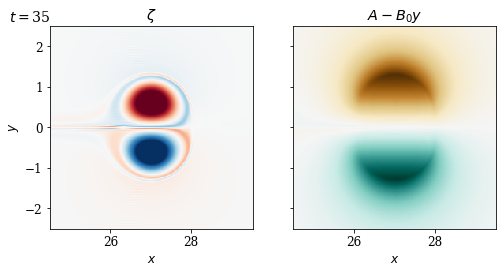

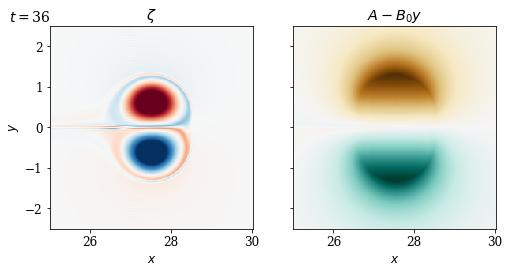

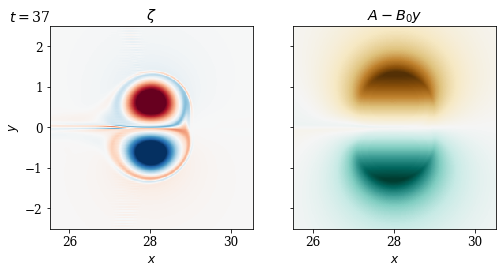

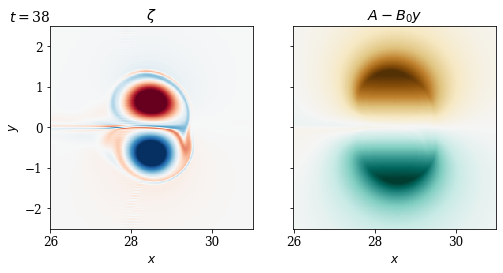

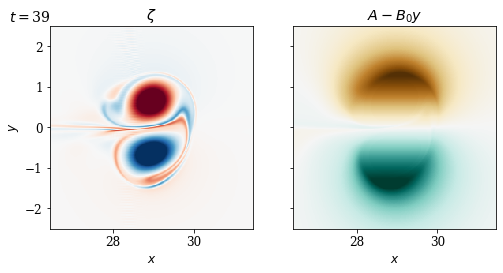

In [8]:
### zoomed version witb anomaly of A
# NO COLORBAR

Lplot = 2.5
amp_vort = 8
amp_B = .25
    
slih = slice(-Lplot, Lplot)
tplots = np.arange(31, 40, 1).tolist()
cbar_kwargs = {"orientation":"vertical", "label":None, "fraction":.04}

hpc = {}
for it,tt in enumerate(tplots):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4.5))
    ax = axs[0] # streamfunction
    sds = ds_roll.sel(t=tt, method="nearest").sel(x=slih, y=slih)
    sds["x"] = sds.x + sds.x_pos
    #xplot, yplot = sds.x.values, sds.y.values
    #psi = sds.psi.transpose("y", "x").values
    #hpc["psi"] = axs[0].contourf(xplot, yplot, psi, cmap=cmaps["psi"], 
    #                                levels=levs_psi, extend="both")
    #plt.colorbar(hpc["psi"], ax=ax, label="psi", **cbar_kwargs)
    hpc["vort"] = sds.vort.plot(ax=ax, cmap=cmaps["vort"], vmin=-amp_vort, vmax=amp_vort, y="y", 
                                add_colorbar=False)
    ax.set_title(r"$\zeta$")
    ax = axs[1]
    hpc["B"] = sds.b.plot(ax=ax, cmap=cmaps["B"], y="y", vmin=-amp_B, vmax=amp_B, 
                          add_colorbar=False)
    ax.set_title(r"$A-B_0y$")
    for ia,ax in enumerate(axs):
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'')
        ax.set_aspect(1)

    axs[0].set_ylabel(r'$y$')
    axs[0].text(-.2, 1.02, r"$t=$"+"{:.0f}".format(tt), fontsize=14, transform=axs[0].transAxes)
    
    if True:
        fig_name = simul.name+"_snapzoom-nocbar_t{:02d}.png".format(round(tt))
        fig.savefig(fig_path/fig_name, dpi=250, bbox_inches="tight")

## old second version, not centering the modon

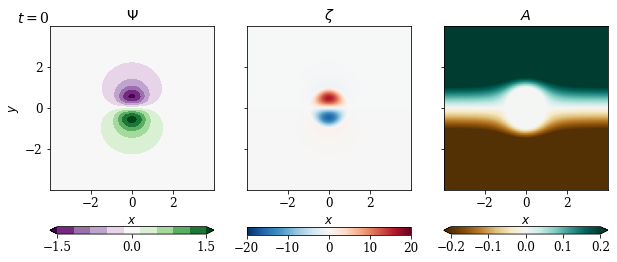

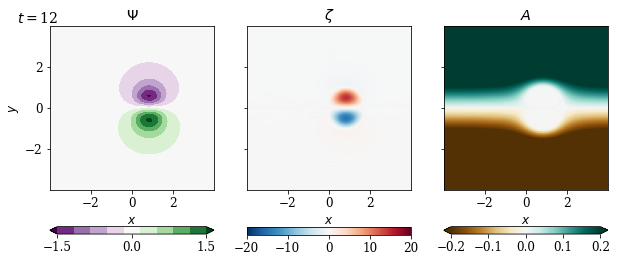

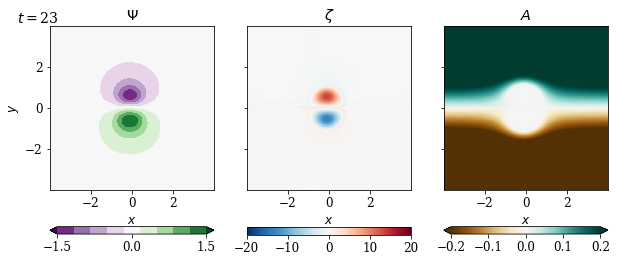

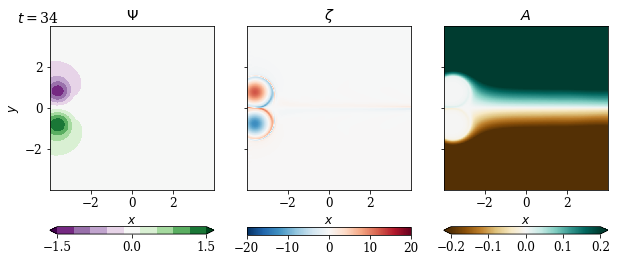

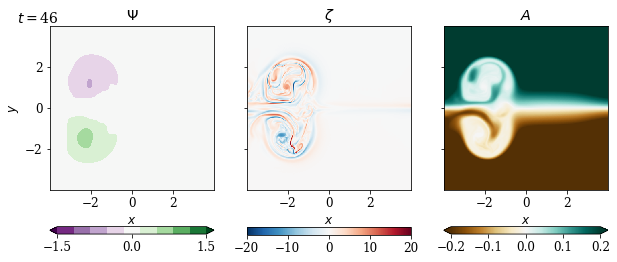

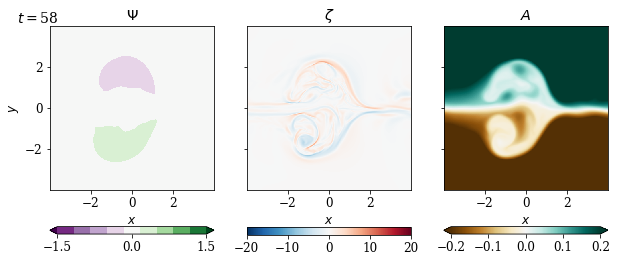

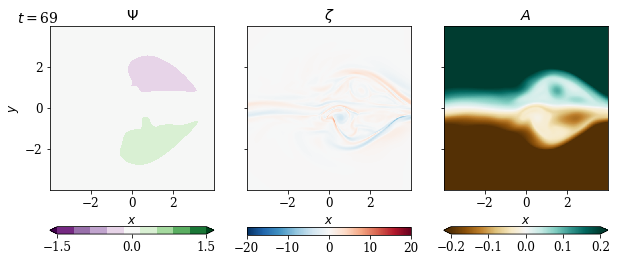

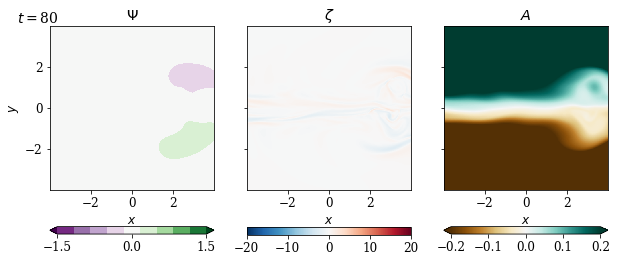

In [14]:
tplots = np.arange(0, 81, 11.5).tolist()
cbar_kwargs = {"orientation":"horizontal", "label":None}

hpc = {}
for it,tt in enumerate(tplots):
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4.5))
    ax = axs[0] # streamfunction
    sds = ds.sel(t=tt, method="nearest").sel(x=slih, y=slih)
    xplot, yplot = sds.x.values, sds.y.values
    #psi = sds.psi.transpose("y", "x").values
    #hpc["psi"] = axs[0].contourf(xplot, yplot, psi, cmap=cmaps["psi"], 
    #                                levels=levs_psi, extend="both")
    #plt.colorbar(hpc["psi"], ax=ax, label="psi", **cbar_kwargs)
    hpp = sds.psi.plot.contourf(ax=ax, y="y", levels=levs_psi, cmap=cmaps["psi"], 
                          extend="both", cbar_kwargs=cbar_kwargs)
    hpp.colorbar.set_ticks([levs_psi[0], 0., levs_psi[-1]])
    ax = axs[1] # vorticity
    hpc["vort"] = sds.vort.plot(ax=ax, cmap=cmaps["vort"], vmin=-amp_vort, vmax=amp_vort, y="y", 
                                cbar_kwargs=cbar_kwargs)
    ax.set_title("")
    ax = axs[2]
    hpc["B"] = (sds.b+amp_B*sds.y).plot(ax=ax, cmap=cmaps["B"], y="y", vmin=-amp_B, vmax=amp_B, 
                          cbar_kwargs=cbar_kwargs)
    ax.set_title("")
  
    for ia,ax in enumerate(axs):
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'')
        ax.set_aspect(1)
        ax.set_title(tits[ia])

    axs[0].set_ylabel(r'$y$')
    axs[0].text(-.2, 1.02, r"$t=$"+"{:.0f}".format(tt), fontsize=14, transform=axs[0].transAxes)
    
    if False:
        fig_name = simul.name+"_snapshot_t{:02d}.png".format(round(tt))
        fig.savefig(fig_path/fig_name, dpi=250, bbox_inches="tight")